# Bài tập lab-02 -- So khớp ảnh sử dụng Histogram
* MSSV: 22520236
* Trần Quang Đạt

In [11]:
import cv2
import numpy as np
import os
import random
from scipy.spatial import distance
from matplotlib import pyplot as plt



* Tính toán histogram

In [12]:
def calculate_histogram(image):
    # Chuyển đổi ảnh sang HSV và tính toán histogram
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Tính histogram cho 3 kênh màu (Hue, Saturation, Value)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

* Tìm ảnh tương đồng bằng cách so sánh khoảng cách Euclide giữa histogram ảnh đầu vào và các ảnh trong tập seg

In [13]:
def find_similar_images(input_image_path, dataset_folder, top_n=10):
    # Đọc và tính toán histogram của ảnh đầu vào
    input_image = cv2.imread(input_image_path)
    input_hist = calculate_histogram(input_image)
    similarities = []
    
    # Duyệt qua các thư mục con trong dataset_folder (tập seg)
    for folder in os.listdir(dataset_folder):
        folder_image = os.path.join(dataset_folder, folder)
        
        # Kiểm tra nếu folder_image là thư mục thì mới tiếp tục
        if os.path.isdir(folder_image):
            for filename in os.listdir(folder_image):
                image_path = os.path.join(folder_image, filename)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Tính histogram cho ảnh trong dataset
                    test_hist = calculate_histogram(image)
                    # Tính khoảng cách Euclide giữa histogram của ảnh đầu vào và các ảnh trong dataset
                    dist = distance.euclidean(input_hist, test_hist)
                    similarities.append((image_path, dist))
    
    # Sắp xếp các ảnh theo khoảng cách (tăng dần, ảnh có khoảng cách nhỏ nhất là ảnh giống nhất)
    similarities.sort(key=lambda x: x[1])
    
    # Trả về top N ảnh giống nhất
    return similarities[:top_n]


* tạo subplots để hiển thị ảnh đầu vào và top 10 ảnh giống nhất

In [14]:
def display_images(input_image_path, similar_images):
    # Tạo một lưới với 3 hàng và 5 cột, hàng đầu tiên chứa ảnh đầu vào, hai hàng sau chứa 10 ảnh giống nhất
    fig, ax = plt.subplots(3, 5, figsize=(15, 10))
    ax = ax.ravel()  # Đưa về dạng mảng 1D
    
    # Hiển thị ảnh đầu vào ở hàng đầu tiên
    input_image = cv2.imread(input_image_path)
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(input_image_rgb)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    # Ẩn các ô còn lại ở hàng đầu tiên (4 ô trống)
    for i in range(1, 5):
        ax[i].axis('off')

    # Hiển thị 10 ảnh giống nhất ở hai hàng còn lại
    for i, (image_path, dist) in enumerate(similar_images, 5):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image_rgb)
        ax[i].set_title(f'Distance: {dist:.2f}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


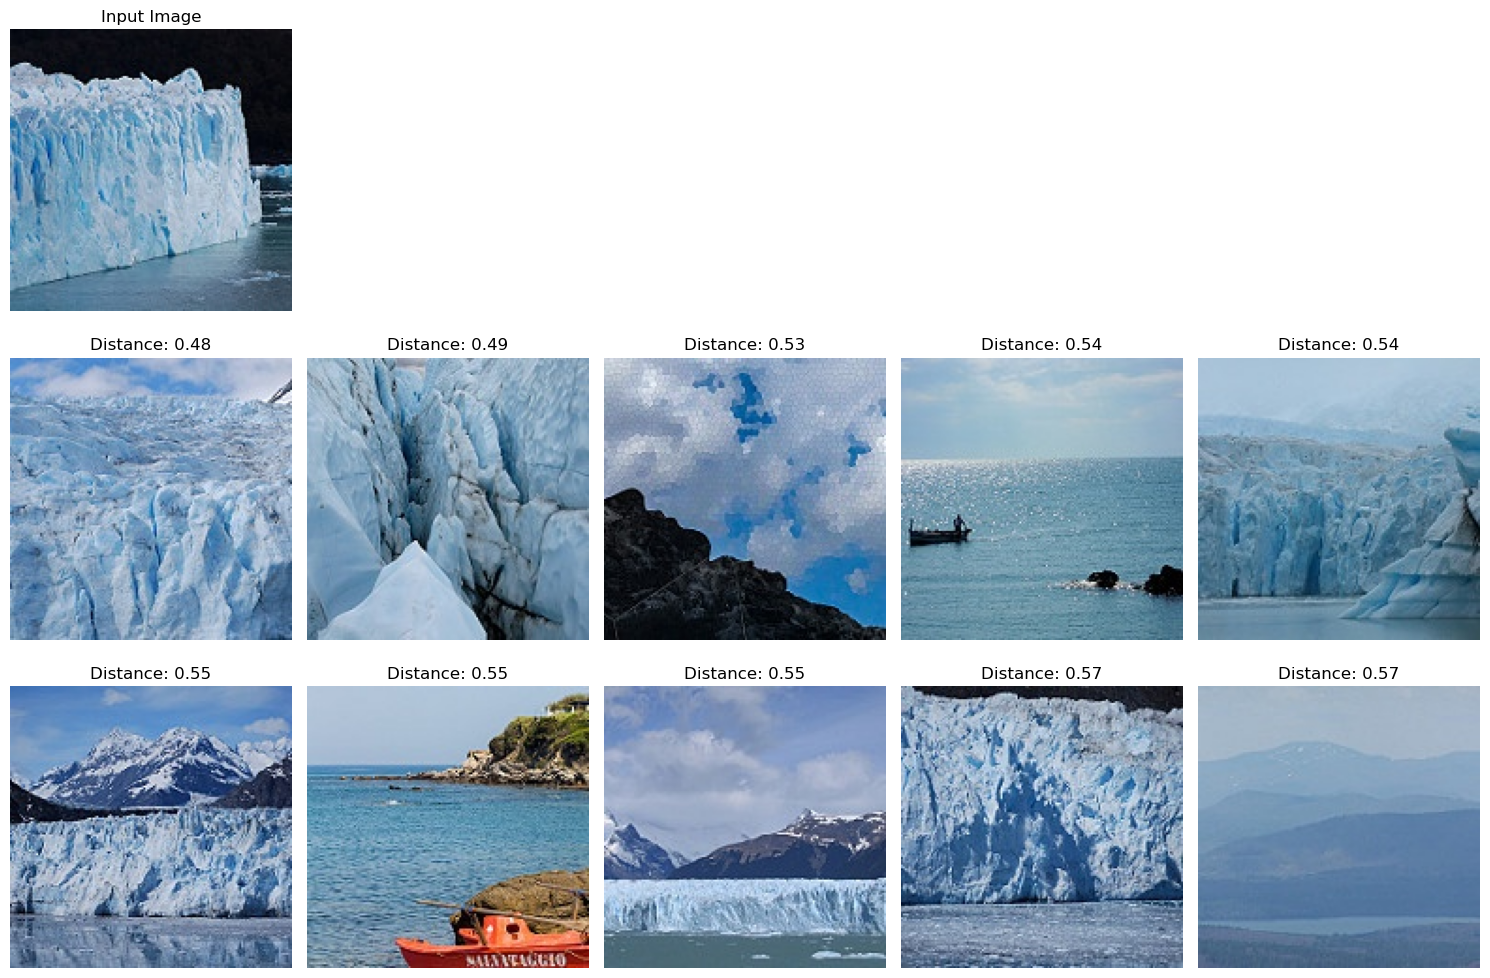

In [15]:
def main():
    # Thư mục chứa tập test và tập truy vấn (seg)
    test_folder = './dataset/seg_test'
    dataset_folder = './dataset/seg'
    
    # Chọn random ảnh trong tập test
    folder_test_images = os.listdir(test_folder)
    random_folder_test_images= random.choice(folder_test_images)
    random_folder_test_images = os.path.join(test_folder, random_folder_test_images)
    
    random_image_path = os.path.join(random_folder_test_images, random.choice(os.listdir(random_folder_test_images)))
    
    

    # Đọc ảnh ngẫu nhiên
    input_image = cv2.imread(random_image_path)
    
    if input_image is None:
        print("Không thể đọc ảnh từ tập test.")
        return
    
    
    # Tìm 10 ảnh giống nhất trong tập seg
    similar_images = find_similar_images(random_image_path, dataset_folder)
    
    # Hiển thị ảnh đầu vào và 10 ảnh giống nhất
    display_images(random_image_path, similar_images)

# Chạy chương trình
if __name__ == "__main__":
    main()

# Sử dụng Khoảng cách Chi-Square (Chi-squared Distance) thay vì Euclide


In [22]:
from scipy.stats import chisquare


In [23]:
def calculate_chisquare(hist1, hist2):
    # Tránh chia cho 0 bằng cách thêm epsilon vào mỗi giá trị
    epsilon = 1e-10
    hist1 += epsilon
    hist2 += epsilon
    
    # Tính khoảng cách Chi-Square
    chisq_distance = chisquare(hist1, hist2)[0]
    return chisq_distance

In [24]:
def find_similar_images_ChiSquar(input_image_path, dataset_folder, top_n=10):
    # Đọc và tính toán histogram của ảnh đầu vào
    input_image = cv2.imread(input_image_path)
    input_hist = calculate_histogram(input_image)
    similarities = []
    
    # Duyệt qua các ảnh trong thư mục dataset (tập seg)
    for folder in os.listdir(dataset_folder):
        folder_image = os.path.join(dataset_folder, folder)
        
        if os.path.isdir(folder_image):
            for filename in os.listdir(folder_image):
                image_path = os.path.join(folder_image, filename)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Tính histogram cho ảnh trong dataset
                    test_hist = calculate_histogram(image)
                    # Sử dụng hàm calculate_chisquare để so sánh
                    dist = calculate_chisquare(input_hist, test_hist)
                    similarities.append((image_path, dist))
    
    # Sắp xếp các ảnh theo khoảng cách (tăng dần, ảnh có khoảng cách nhỏ nhất là ảnh giống nhất)
    similarities.sort(key=lambda x: x[1])
    

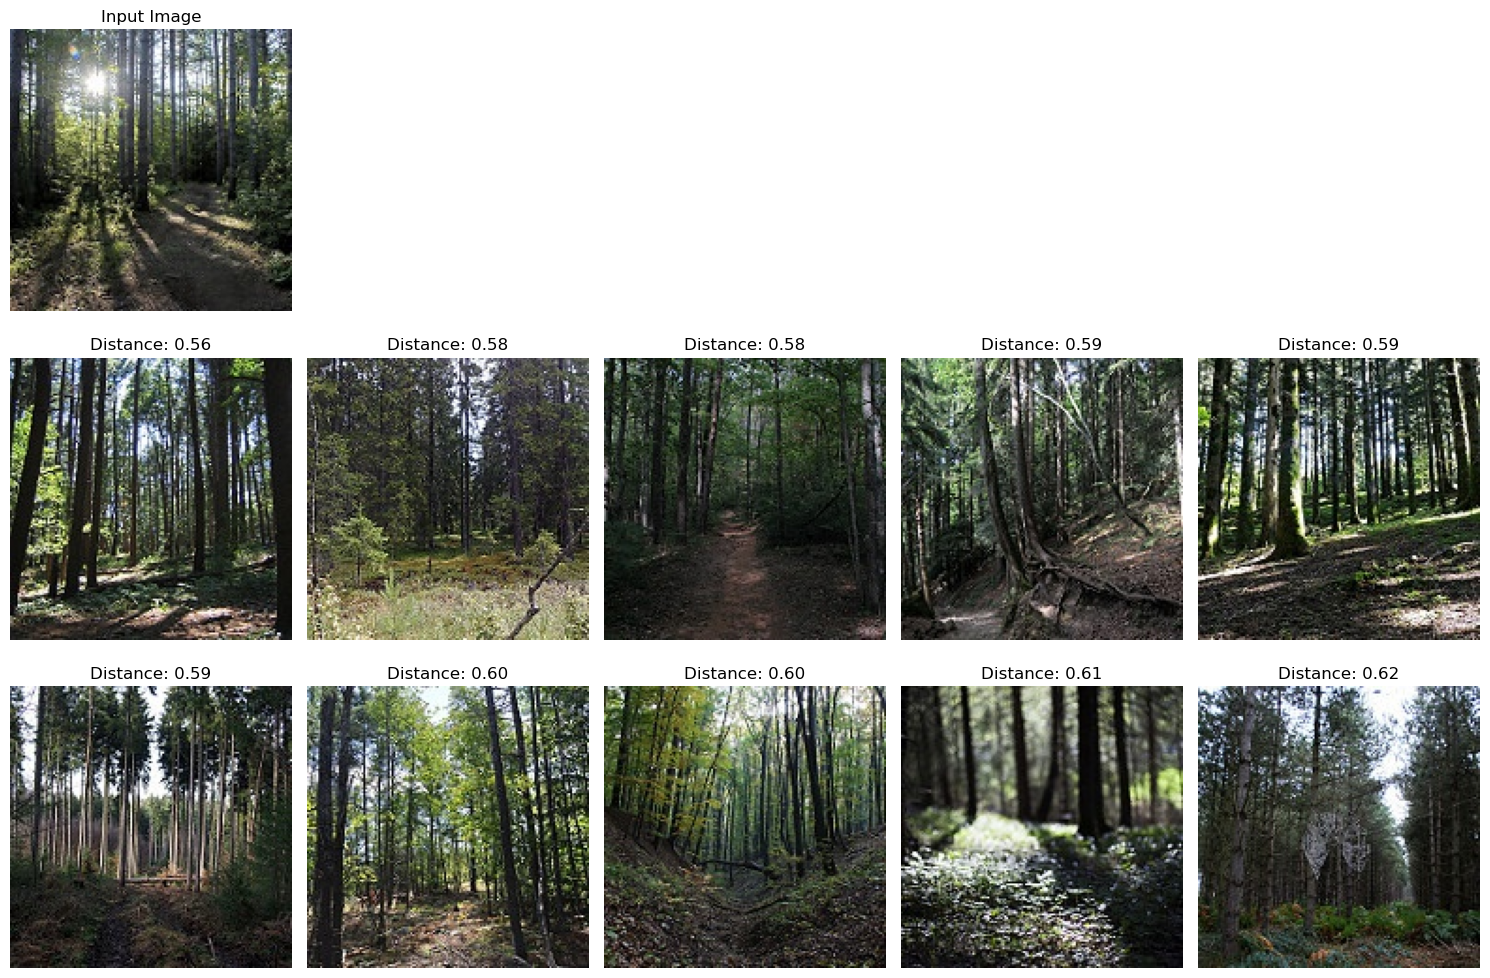

In [30]:
test_folder = './dataset/seg_test'
dataset_folder = './dataset/seg'
    
# chọn random ảnh trong tập test
folder_test_images = os.listdir(test_folder)
random_folder_test_images= random.choice(folder_test_images)
random_folder_test_images = os.path.join(test_folder, random_folder_test_images)
    
random_image_path = os.path.join(random_folder_test_images, random.choice(os.listdir(random_folder_test_images)))
    
    

if os.path.isdir(random_folder_test_images):
    random_image_path = os.path.join(random_folder_test_images, random.choice(os.listdir(random_folder_test_images)))

    # Đọc ảnh ngẫu nhiên
    input_image = cv2.imread(random_image_path)

    # Tìm 10 ảnh giống nhất trong tập seg
    similar_images = find_similar_images(random_image_path, dataset_folder)
    
    # Hiển thị ảnh đầu vào và 10 ảnh giống nhất
    display_images(random_image_path, similar_images)
else:
    print("Không tìm thấy thư mục hợp lệ trong tập test.")